# IRIS dataset Exploration 

Our objectives in this notebook are to:

1. Explore and visualize the Iris dataset to gain insights into its structure and patterns.
2. Prepare the data for machine learning tasks.
3. Implement and compare different classification models.
4. Select the best-performing model through rigorous evaluation.
5. Interpret the results and draw conclusions.
6. Save the trained model for real time inference

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import pickle as pkl

In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [3]:
# Set float display format in pandas to 2 decimals
pd.options.display.float_format = "{:,.2f}".format

In [4]:
# Set random seed for reproducibility and other global variables
SEED = 0xbadc0de
TEST_SIZE = 0.2
MODEL_LOCATION = "../models/rdf.pkl"
np.random.seed(SEED)

### 1. Load dataset

In [5]:
# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target
feature_names = iris.feature_names
target_names = iris.target_names
# remove (cm) from featuer names
feature_names = [feature_name.split("(cm)")[0] for feature_name in feature_names ]

### 2. Build Dataframe and get basic information

In [6]:
# Create a DataFrame for easier data manipulation
df = pd.DataFrame(X, columns=feature_names)

In [7]:
# Display basic information about the dataset
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sepal length   150 non-null    float64
 1   sepal width    150 non-null    float64
 2   petal length   150 non-null    float64
 3   petal width    150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


There are no nulls in our dataset. Yaay !

In [8]:
print("Dataset Summary Statistics:")
df.describe()

Dataset Summary Statistics:


,sepal length,sepal width,petal length,petal width
count,150.00,150.00,150.00,150.00
mean,5.84,3.06,3.76,1.20
std,0.83,0.44,1.77,0.76
min,4.30,2.00,1.00,0.10
25%,5.10,2.80,1.60,0.30
50%,5.80,3.00,4.35,1.30
75%,6.40,3.30,5.10,1.80
max,7.90,4.40,6.90,2.50


In [9]:
# add target column to our dataframe
df['target'] = y

### 3. Visualizations

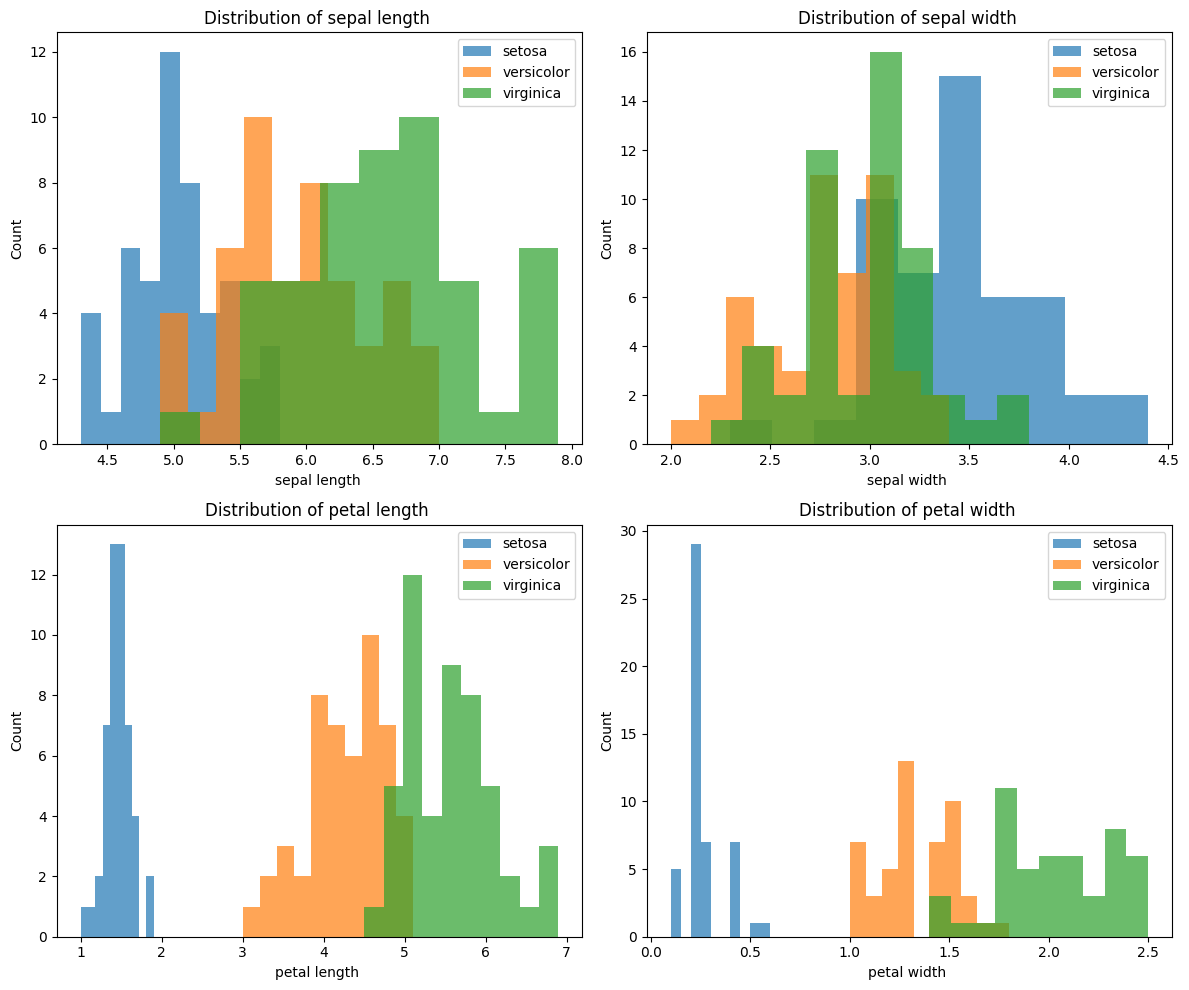

In [10]:
# Visualize the distribution of features
plt.figure(figsize=(12, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(2, 2, i+1)
    for target in range(3):
        plt.hist(df[df['target'] == target][feature], bins=10, alpha=0.7, label=target_names[target])
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend()
plt.tight_layout()
plt.show()

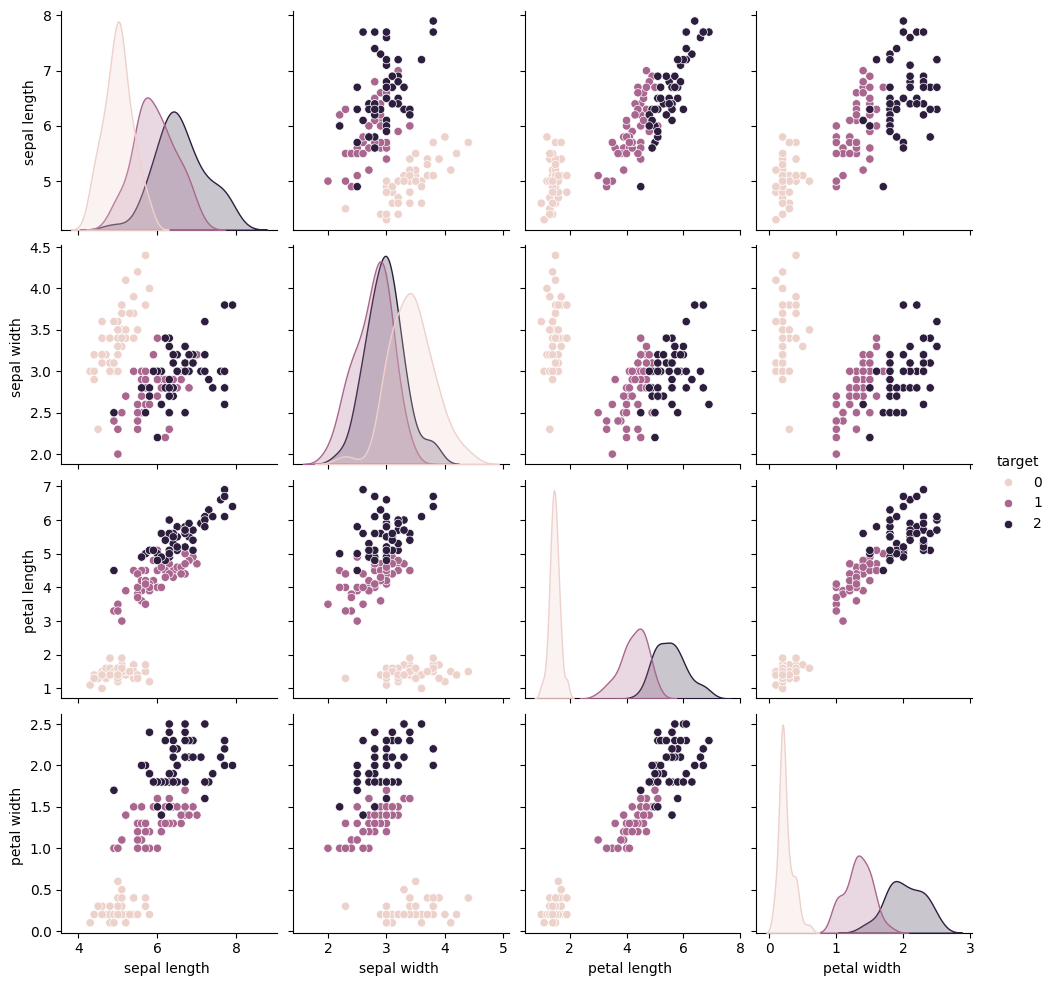

In [11]:
# Visualize pairwise relationships between features
sns.pairplot(df, hue='target', vars=feature_names)
plt.show()


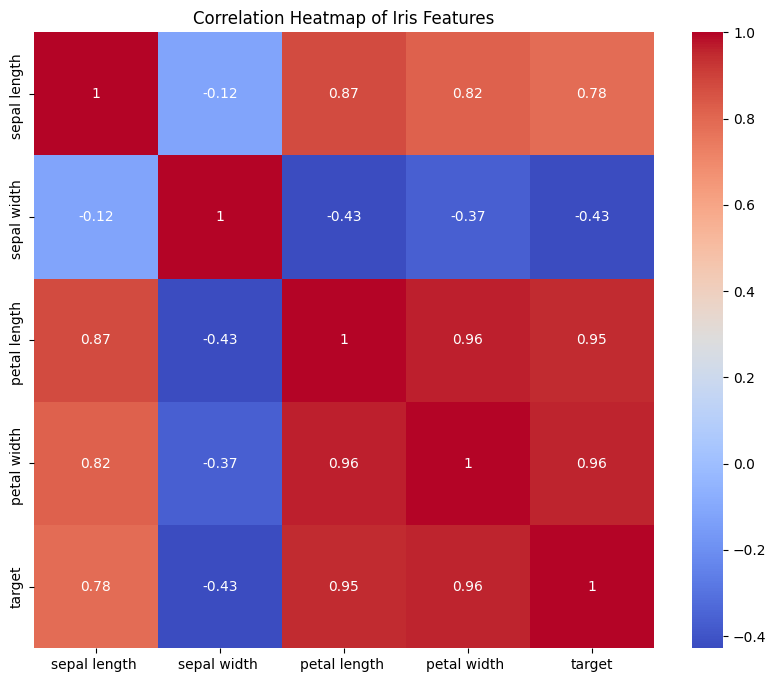

In [12]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Iris Features')
plt.show()


There is a high correlation between the Target, Petal length and Petal width. We expect these 2 features to have a big contribution in the model prediction

### 4. Model selection

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

In [14]:
# Define pipelines for different models
pipelines = {
    'svm': Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC())
    ]),
    'rf': Pipeline([
        ('rf', RandomForestClassifier())
    ])
}

In [15]:
# Define search space
param_grids = {
    'svm': {
        'scaler__with_mean' : [True, False],
        'svm__C': [0.1, 1, 10],
        'svm__kernel': ['rbf', 'linear']
    },
    'rf': {
        'rf__n_estimators': [10, 50, 100, 200],
        'rf__max_depth': [None, 10, 20]
    }
}

In [16]:
# Perform GridSearchCV for each model
best_models = {}
for model_name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"\nBest parameters for {model_name}:")
    print(grid_search.best_params_)
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Best parameters for svm:
{'scaler__with_mean': False, 'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score: 0.9583

Best parameters for rf:
{'rf__max_depth': None, 'rf__n_estimators': 100}
Best cross-validation score: 0.9417


In [17]:
best_models

{'svm': Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                 ('svm', SVC(C=10))]),
 'rf': Pipeline(steps=[('rf', RandomForestClassifier())])}

In [18]:
# Select the best model based on cross-validation score
best_model_name = max(best_models, key=lambda x: best_models[x].score(X_train, y_train))
best_model = best_models[best_model_name]

print(f"\nBest model: {best_model_name}")



Best model: rf


In [19]:
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))


Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       1.00      1.00      1.00        11
   virginica       1.00      1.00      1.00         7

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



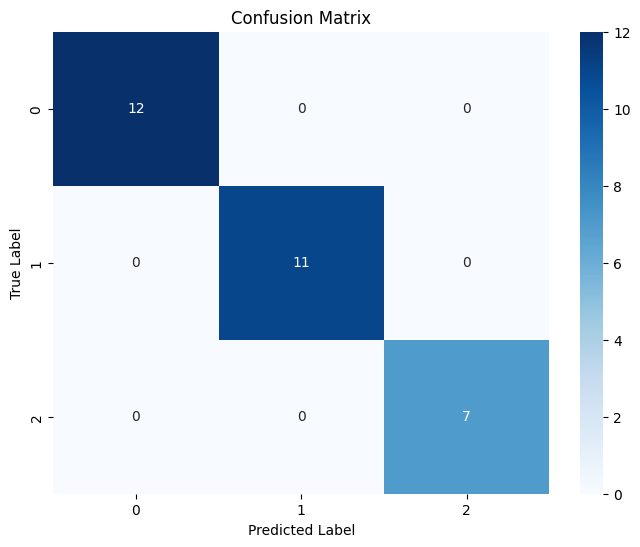

In [20]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

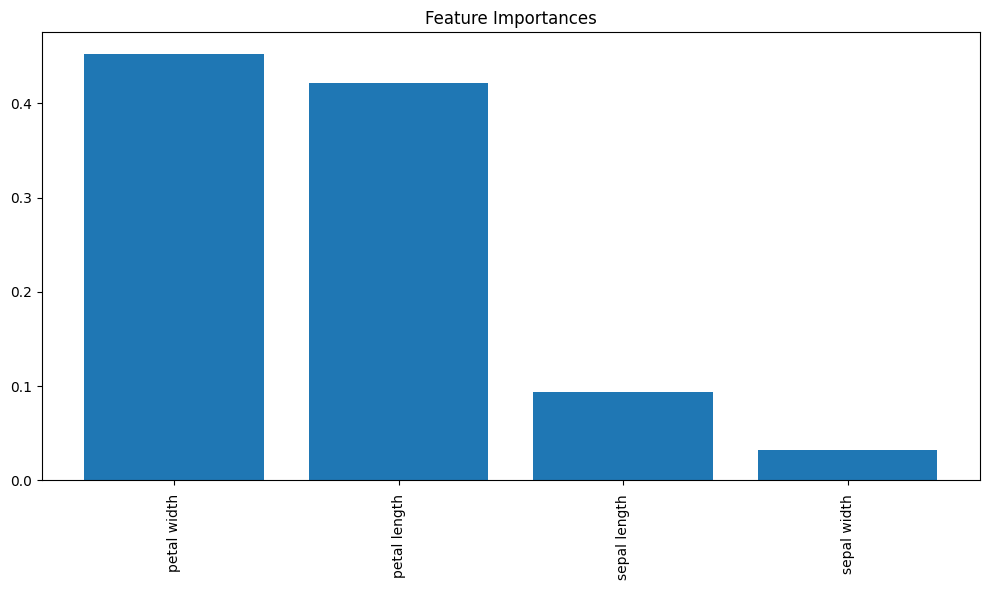

In [21]:
# Feature importance (for Random Forest)
if best_model_name == 'rf':
    importances = best_model.named_steps['rf'].feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

### 6. Conclusion

In [22]:
# Conclusion
print(f"The best model for this dataset is {best_model_name}.")
print(f"It achieved an accuracy of {best_model.score(X_test, y_test):.4f} on the test set.")
print("This model can be used for predicting Iris species based on sepal and petal measurements.")

The best model for this dataset is rf.
It achieved an accuracy of 1.0000 on the test set.
This model can be used for predicting Iris species based on sepal and petal measurements.


### 7. Save trained model

In [24]:
with open(MODEL_LOCATION, "wb") as f : 
    pkl.dump(best_model, f)